In [1]:
import numpy as np
from sympy import *
from matplotlib import pyplot as plt

# 1D Beam Solution

In [2]:
bc = 1  # constrain (or Boundary condition) at node 1
rho = 2.7*10**(-9) # Density of the Bar
I = 300*40**3/12  # Area Moment of Inertia
E = 70000   # Youngs Modulus
A = 300*40   # Cross Section Area
L = 1500  # Length of Bar
F = 4000   # Force at the tip of Bar
numElem = 5  # Number of Elements

In [3]:
le = L/numElem

elem = []
for i in range(numElem):
    elem.append([i+1,i+2])
elem

[[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]

In [4]:
x = Symbol('x')
Le = Symbol('Le')

# Shape Function Matrix
shape = np.matrix([
    (2*(x/le)**3 - 3*(x/le)**2 + 1),
    ((x/le)**3 - 2*(x/le)**2 + (x/le))*le,
    (-2*(x/le)**3 + 3*(x/le)**2),
    ((x/le)**3 - (x/le)**2)*le
])

# Differentiated Shape Function Matrix
shape_d = []
for i in range(shape.shape[1]):
    shape_d.append(diff(diff(np.array(shape[0, i]).flatten()[0], x), x))

shape = np.matrix(shape)
shape_d = np.matrix(shape_d)

In [5]:
# Creating The Local Mass Matrix
m = np.matmul(shape.T, shape)
for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        m[i,j] = simplify(integrate(m[i,j], x).subs(x, Le))

In [6]:
# Creating The Local Stiffness Matrix
k = np.matmul(shape_d.T, shape_d)
for i in range(k.shape[0]):
    for j in range(k.shape[1]):
        k[i,j] = simplify(integrate(k[i,j], x).subs(x, Le))

In [7]:
K = np.zeros([2*len(elem)+2, 2*len(elem)+2])  # Creating initially zero matrix for global Stiffness matrix
M = np.zeros([2*len(elem)+2, 2*len(elem)+2])  # Creating initially zero matrix for global Mass matrix

for i in elem:
    
    temp1 = k.copy()
    for a in range(temp1.shape[0]):
        for j in range(temp1.shape[1]):
            temp1[a,j] = temp1[a,j].subs(Le, le)
    # print(temp1)
    K[2*i[0]-2:2*i[1], 2*i[0]-2:2*i[1]] = K[2*i[0]-2:2*i[1], 2*i[0]-2:2*i[1]] +  (E*I) * temp1
    
    temp2 = m.copy()
    for a in range(temp2.shape[0]):
        for j in range(temp2.shape[1]):
            temp2[a,j] = temp2[a,j].subs(Le, le)
    M[2*i[0]-2:2*i[1], 2*i[0]-2:2*i[1]] = M[2*i[0]-2:2*i[1], 2*i[0]-2:2*i[1]] +  (rho*A) * temp2

In [8]:
# Function to apply Boundary Conditions
def BC(K, bc):
    newK = []
    for i in range(len(K)):
        temp = []
        for j in range(len(K[0])):
            if not(i==bc or j==bc or i==bc+1 or j==bc+1):
                temp.append(K[i][j])
        if temp != []:
            newK.append(temp)
    if newK != []:
        return np.matrix(newK)
    else:
        return np.matrix(K)

In [9]:
# Global Stiffness Matrix After Applying Boundary Conditions
Kc = BC(K, bc-1)
Mc = BC(M, bc-1)

In [10]:
Lam, mode = np.linalg.eig(np.matmul(np.linalg.inv(Mc), Kc))

w = Lam**0.5
freq = np.sort(w/(2*np.pi))
freq

array([  14.62280684,   91.68413617,  257.51168327,  508.71027262,
        844.33242481, 1402.66942753, 2051.41377039, 2975.00264519,
       4226.21564949, 6216.98674136])

In [11]:
from Beam_roots import rootsGen

Act = (1/(2*np.pi*L**2)) * ((E*I/(rho*A))**0.5) * np.flip(np.array(rootsGen(13)[-1]))**2
Act

array([ 14.62260916+0.j,  91.63832736+0.j, 256.5876563 +0.j])

In [12]:
act_freq = Act
fem_freq = []
ind = 0
for i in range(len(freq)):
    fem_freq.append(freq[i])
    ind = ind + 1
    if ind==3:
        break
    
act_freq = np.array(act_freq)
fem_freq = np.array(fem_freq)

print('Actual Frequencies:', act_freq)
print('FEM Frequencies:', fem_freq)
print('% Error:', (act_freq-fem_freq)*100/act_freq)

Actual Frequencies: [ 14.62260916+0.j  91.63832736+0.j 256.5876563 +0.j]
FEM Frequencies: [ 14.62280684  91.68413617 257.51168327]
% Error: [-0.00135191+0.j -0.0499887 +0.j -0.36012136+0.j]


# Plotting the Modes Shapes of a 1D Beam

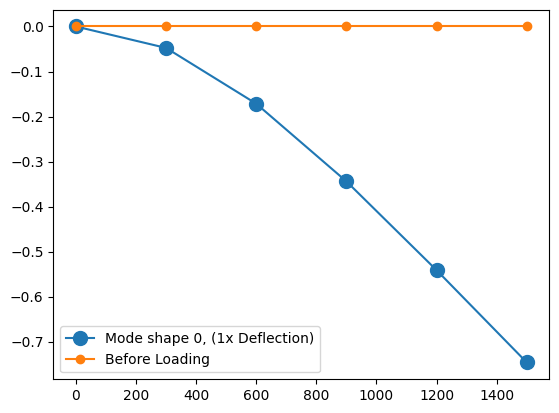

In [13]:
ModeNo = 1
Multiplier = 1

mm = []
for j in range(len(mode.T)-1, -1, -1):
    temp = []
    for i in range(1, mode.T.shape[1]+1):
        if i%2!=0:
            temp.append(mode.T[j, i-1])
    mm.append(temp)
mm = np.matrix(mm)
        
x1 = [[0]]
te = 0
for i in range(mm.shape[1]):
    te = te + le
    x1.append([te])
x1 = np.matrix(x1)

x = [[0]]
te = 0
for i in range(mm.shape[1]):
    te = te + ((le)**2 - (mm[ModeNo-1,i]*Multiplier)**2)**0.5
    x.append([te])
x = np.matrix(x)

y = [[0]]
te = 0
for i in range(mm.shape[1]):
    te = mm[ModeNo-1,i]*Multiplier
    y.append([te])
y = np.matrix(y)


plt.plot(x, y, marker='o', color='tab:blue', markersize=10, label=f'Mode shape {ModeNo-1}, ({Multiplier}x Deflection)')


plt.plot(x1, np.zeros([x1.size,1]), marker='o', color='tab:orange', label='Before Loading')
plt.legend()